In [312]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import datetime

In [313]:
Price = pd.read_csv('DCOILWTICO.csv')
Price.head()

,DATE,DCOILWTICO
0,2/21/17 12:00 AM,54.02
1,2/22/17 12:00 AM,53.61
2,2/23/17 12:00 AM,54.48
3,2/24/17 12:00 AM,53.99
4,2/27/17 12:00 AM,54.04


In [314]:
Price['DATE']= pd.to_datetime(Price['DATE']).map(lambda d: d.strftime('%Y-%m-%d'))
Price['DATE'] = Price['DATE'].astype('datetime64[ns]') 
Price['Year'] = pd.DatetimeIndex(Price['DATE']).year
Price['Month'] = pd.DatetimeIndex(Price['DATE']).month
Price['Day'] = pd.DatetimeIndex(Price['DATE']).day


In [315]:
Price['DayWeek'] = ""
for k in range(len(Price)):
    Price.DayWeek.iloc[k] = datetime.date(Price.Year.iloc[k], Price.Month.iloc[k], Price.Day.iloc[k]).strftime("%A")


//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [316]:
#Price = Price.loc[Price['Year'] >=2019]
print(Price.loc[Price['DCOILWTICO'] == '.'])

          DATE DCOILWTICO  Year  Month  Day    DayWeek
38  2017-04-14          .  2017      4   14     Friday
69  2017-05-29          .  2017      5   29     Monday
94  2017-07-03          .  2017      7    3     Monday
95  2017-07-04          .  2017      7    4    Tuesday
139 2017-09-04          .  2017      9    4     Monday
197 2017-11-23          .  2017     11   23   Thursday
219 2017-12-25          .  2017     12   25     Monday
224 2018-01-01          .  2018      1    1     Monday
234 2018-01-15          .  2018      1   15     Monday
259 2018-02-19          .  2018      2   19     Monday
288 2018-03-30          .  2018      3   30     Friday
329 2018-05-28          .  2018      5   28     Monday
356 2018-07-04          .  2018      7    4  Wednesday
399 2018-09-03          .  2018      9    3     Monday
457 2018-11-22          .  2018     11   22   Thursday
458 2018-11-23          .  2018     11   23     Friday
479 2018-12-24          .  2018     12   24     Monday
480 2018-1

#### Empty cells are national (USA)/international holidays, for instance : NY, MLK day, President's day, Christmas, etc. Trading is suspended on these days. We can either delete these cells, or replace the prices using nearest neighbors,monthly/weekly mean, etc. 

#### Artificially computing the prices for these days would bias the analysis and lower the accuracy, as the articles published (if any) on these days would suggest potentially different trends, we will therefore impute them.

In [317]:
Holidays = Price.loc[Price['DCOILWTICO'] == '.'] #We store these rows as reference/potential future use
print(Holidays.head())
Price = Price.loc[Price['DCOILWTICO'] != '.'] #We erase them from the original dataset to allow calculations without issues.
print(Price.head())

          DATE DCOILWTICO  Year  Month  Day  DayWeek
38  2017-04-14          .  2017      4   14   Friday
69  2017-05-29          .  2017      5   29   Monday
94  2017-07-03          .  2017      7    3   Monday
95  2017-07-04          .  2017      7    4  Tuesday
139 2017-09-04          .  2017      9    4   Monday
        DATE DCOILWTICO  Year  Month  Day    DayWeek
0 2017-02-21      54.02  2017      2   21    Tuesday
1 2017-02-22      53.61  2017      2   22  Wednesday
2 2017-02-23      54.48  2017      2   23   Thursday
3 2017-02-24      53.99  2017      2   24     Friday
4 2017-02-27      54.04  2017      2   27     Monday


#### We calculate the relative change (Which is a percentage) in the price between two consecutive observations to check if the prices have dropped or rised.

In [318]:
Price['relchange'] = np.zeros(len(Price))

Price['price'] = pd.to_numeric(Price.DCOILWTICO)

for i in range(1,len(Price)): #We start from 1 and not 0
    Price.relchange.iloc[i] = (Price.price.iloc[i] - Price.price.iloc[i-1])*100/Price.price.iloc[i]
    

In [319]:
Price['evolution'] = ""

Price.evolution.loc[Price['relchange'] >= 0] = 'Up'
Price.evolution.loc[Price['relchange'] < 0] = 'Down'


#Price.evolution[Price.relchange < 0] = 
#Price.evolution[Price.relchange > 0] = 'Up'
Price.head()

,DATE,DCOILWTICO,Year,Month,Day,DayWeek,relchange,price,evolution
0,2017-02-21,54.02,2017,2,21,Tuesday,0.000000,54.02,Up
1,2017-02-22,53.61,2017,2,22,Wednesday,-0.764783,53.61,Down
2,2017-02-23,54.48,2017,2,23,Thursday,1.596916,54.48,Up
3,2017-02-24,53.99,2017,2,24,Friday,-0.907575,53.99,Down
4,2017-02-27,54.04,2017,2,27,Monday,0.092524,54.04,Up


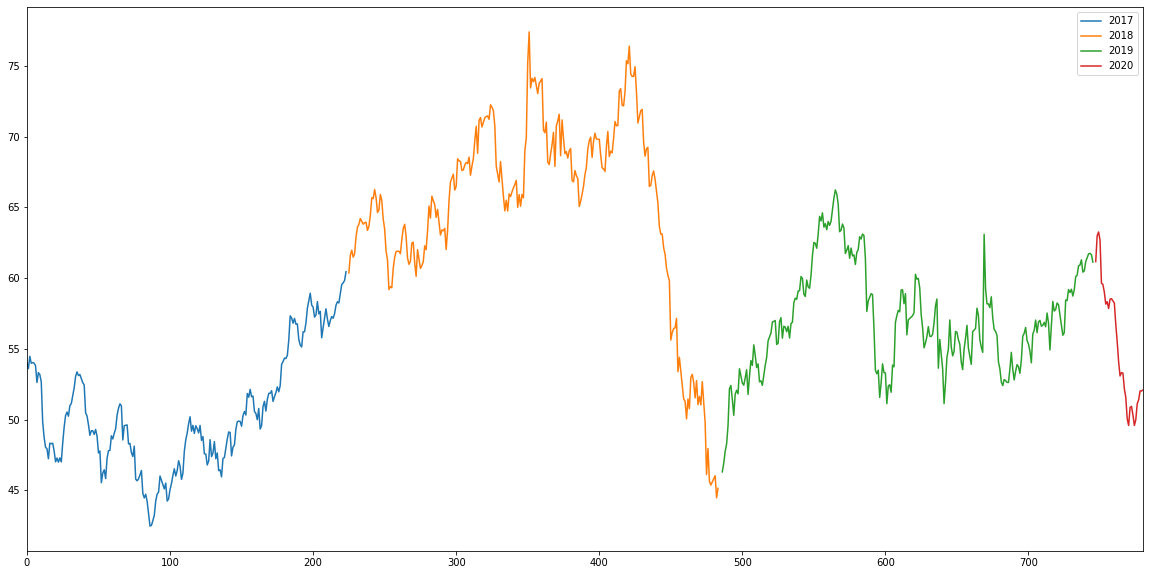

In [329]:
plt.figure(figsize=(20,10))
Price.groupby('Year')['price'].plot(legend='True')
plt.show()

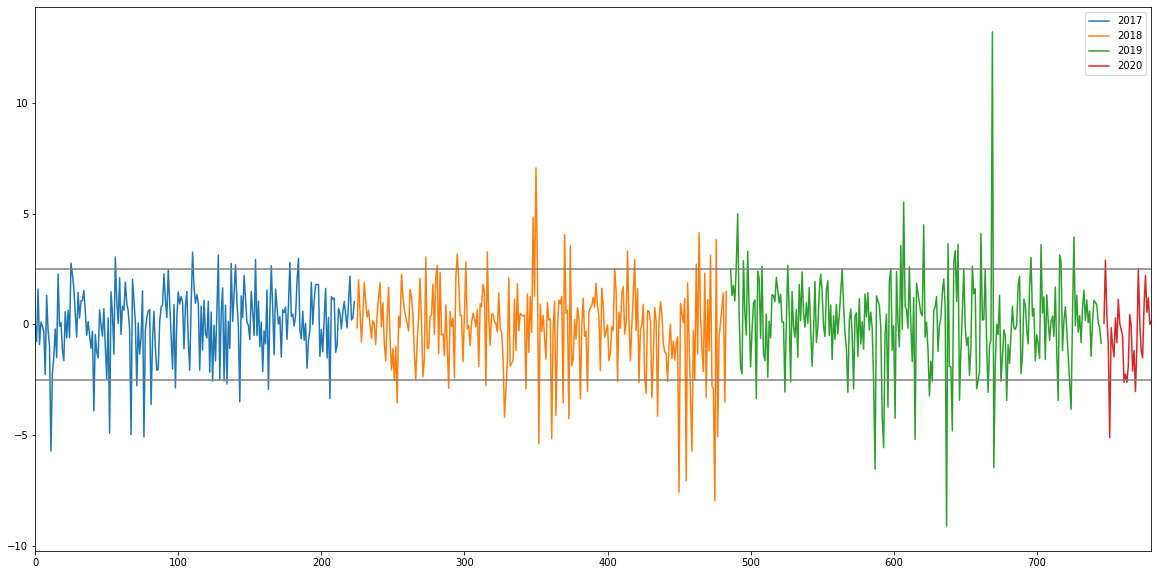

In [335]:
plt.figure(figsize=(20,10))
Price.groupby('Year')['relchange'].plot(legend='True')
plt.axhline(y=2.5, color = 'Grey')
plt.axhline(y= -2.5, color = 'Grey')

plt.show()

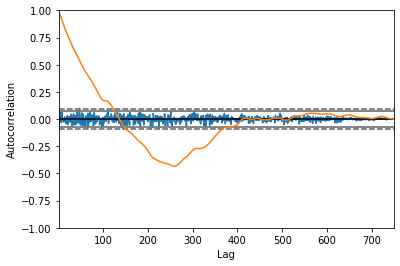

In [339]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(Price.relchange)
autocorrelation_plot(Price.price)


#### Let's import the articles and merge them with the price data

In [504]:
articles = pd.read_csv('articlesfinal.csv')
articles['date']= pd.to_datetime(articles['date']).map(lambda d: d.strftime('%Y-%m-%d'))
#articles.info()

In [579]:
articles['price'] = np.zeros(len(articles))
articles['relchange'] = np.zeros(len(articles))

for D in articles.date.unique(): 
        p = Price.price[Price.date == D]
        for i in (articles[articles.date == D].index.tolist()):
            articles.price[i] = p



In [581]:
articles

,ID,title,link,date,summary,image_link,article_id,text,relchange,price,evolution,Year,Month,Day,DayWeek
0,0,Oil Is Now More Volatile Than Bitcoin,https://oilprice.com/Energy/Oil-Prices/Oil-Is-...,25/02/2020,You know that the oil markets have truly gone ...,https://d32r1sh890xpii.cloudfront.net/article/...,0,You know that the oil markets have truly gone ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,China‚Äôs Floods The Market With Fuel As Coron...,https://oilprice.com/Energy/Crude-Oil/Chinas-F...,25/02/2020,China‚Äôs fuel exports are booming amid batter...,https://d32r1sh890xpii.cloudfront.net/article/...,1,China‚Äôs fuel exports are booming amid batter...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Supersizing The Solar Industry,https://oilprice.com/Energy/Energy-General/Sup...,25/02/2020,There‚Äôs a new trend in solar energy projects...,https://d32r1sh890xpii.cloudfront.net/article/...,2,There‚Äôs a new trend in solar energy projects...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Oil Falls Below $50 On Demand Fears,https://oilprice.com/Energy/Energy-General/WTI...,25/02/2020,If you haven't received our latest Global Ener...,https://d32r1sh890xpii.cloudfront.net/article/...,3,If you haven't received our latest Global Ener...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Saudi Arabia: OPEC Should Pay Serious Attentio...,https://oilprice.com/Energy/Crude-Oil/Saudi-Ar...,25/02/2020,The OPEC+ group should not be complacent about...,https://d32r1sh890xpii.cloudfront.net/article/...,4,The OPEC+ group should not be complacent about...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Coronavirus Punches Hole In Oil Market That OP...,https://oilprice.com/Energy/Oil-Prices/Coronav...,25/02/2020,The coronavirus epidemic is a black swan that ...,https://d32r1sh890xpii.cloudfront.net/article/...,5,The coronavirus epidemic is a black swan that ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,No Financing And No Demand: Chinese Refiners R...,https://oilprice.com/Energy/Crude-Oil/No-Finan...,25/02/2020,International banks are suspending credit line...,https://d32r1sh890xpii.cloudfront.net/article/...,6,International banks are suspending credit line...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,Oil Falls To $50 As Sentiment Sours,https://oilprice.com/Energy/Oil-Prices/Oil-Fal...,25/02/2020,Oil prices erased Asian-trade-hours gains and ...,https://d32r1sh890xpii.cloudfront.net/article/...,7,Oil prices erased Asian-trade-hours gains and ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Oil Tanks On Fears Of Global Economic Crisis,https://oilprice.com/Energy/Oil-Prices/Oil-Tan...,24/02/2020,Global equities fell sharply on Monday as fear...,https://d32r1sh890xpii.cloudfront.net/article/...,8,Global equities fell sharply on Monday as fear...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,3 Energy Sectors Most Threatened By The Corona...,https://oilprice.com/Energy/Energy-General/3-E...,24/02/2020,At a time when the energy sector is weighed do...,https://d32r1sh890xpii.cloudfront.net/article/...,9,At a time when the energy sector is weighed do...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
